# Importing libraries.

In [244]:
import numpy as np 
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import math
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split , RepeatedStratifiedKFold , cross_val_score , RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix , f1_score ,roc_auc_score ,classification_report , roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = 100


# Importing DataSet and Preprocessing 

In [245]:
df = pd.read_csv('TAB_TEST_PY.csv')
mean = ['balance_deal_sum','WOE_balance_deal_sum']
for i in mean:
    df[i].fillna(df[i].mean(),inplace = True)
df.drop('DealID',axis = 1,inplace = True)
df['RepDate_end'] = pd.to_datetime(df['RepDate_end'],format='%Y%m%d', errors='ignore')
df['RepDate_end'] = df['RepDate_end'].apply(str)
df['RepDate_end'] = df['RepDate_end'].apply(lambda x:x.split(' 00')[0])

# 2.Calculate Gini for Train and Test Sample

In [246]:
def X_train_X_test(train,test):
    X_train = train.drop(target,axis = 1)
    y_train = train[target]
    X_test = test.drop(target,axis = 1)
    y_test = test[target]
    
    model = LogisticRegression()
    model.fit(X_train,y_train)
    train_predict = model.predict(X_train)
    train_gini = roc_auc_score(y_train,train_predict)*2 - 1
    test_predict = model.predict(X_test)
    test_gini = roc_auc_score(y_test,test_predict)*2 - 1
    Gini_Data_Frame = pd.DataFrame(columns = ['Train','Test'])
    return Gini_Data_Frame
#X_train_X_test()

# 3.Calculate Gini over time for each month on Full sample

In [247]:
woe_char = df.iloc[:,20:]
woe_char.drop('Scores',axis = 1,inplace = True)
woe_char['will_default'] = np.where(woe_char['will_default'].isin([0]),1,0)
training = df.iloc[:,1:40]

def ginni_over_month(df,date,training,target,rotation):
    dict = {}
    sorted_date =  sorted(df[date].unique())
    scores = []
    job = df.copy()
    job = df.drop(['RepDate_end'],axis = 1)
    complete = pd.DataFrame(columns = training.columns.values)
    for i in sorted_date: 
        
        dict[i] = [x for x in df.loc[df[date] == i].index]
        
        
        clon = pd.DataFrame(data = job , index = dict[i][0:])
        
        X_train = clon.drop(target,axis = 1)
        y_train = clon[target]
        y_pred = model.predict(X_train)
        roc_auc = roc_auc_score(y_train,y_pred)
        GINI = roc_auc*2 - 1
        scores.append(GINI)
        result = pd.DataFrame({'Date':sorted_date,'Gini':GINI})
        return result
#gini_over_month()

# 4. Calculate Gini for each WOE characteristic on Train and Test samples

In [248]:
woe_train = woe_char.iloc[0:280000,:]
woe_test = woe_char.iloc[280000:,:]
def Gini_for_charact(train,test,woe_char):
    train = pd.DataFrame(data = train,columns = woe_char.columns.values)
    test = pd.DataFrame(data = test,columns = woe_char.columns.values)
    list = [train,test]
    scores = []
    for i in list:
        for g in i.columns[:-1]:
            
            gini = roc_auc_score(i.iloc[:,-1].values,i[g])*2 - 1
            
            scores.append(gini)
    train_scores = scores[0:19]
    test_scores = scores[19:]
    summary = pd.DataFrame({'Woe_Characteristics':woe_char.columns.values[:-1] , 'Train_Gini':train_scores , 'Test_Gini': test_scores})
    return summary
Gini_for_charact(woe_train,woe_test,woe_char)

,Woe_Characteristics,Train_Gini,Test_Gini
0,WOE_balance_deal_sum,0.103846,0.074978
1,WOE_mob,0.000000,0.000000
2,WOE_max_dpd_1,0.746694,0.732446
3,WOE_max_dpd_3,0.788860,0.775093
4,WOE_max_dpd_6,0.798432,0.773995
5,WOE_max_dpd_12,0.000000,0.000000
6,WOE_mnths_snc_dpd_gt_0,0.720311,0.700590
7,WOE_mnths_snc_dpd_gt_30,0.585271,0.564831
8,WOE_mnths_snc_dpd_gt_60,0.000000,0.000000
9,WOE_prc_of_month_with_DPD_grt_0_3_months,0.715431,0.711421


# 5. Calculate Gini for each WOE characteristic over time for each month on Full sample

In [249]:
def Gini_for_charact(df,woe_char):
    train = pd.DataFrame(data = woe_char,columns = woe_char.columns.values)
    sorted_date = sorted(df['RepDate_end'].unique())
    dict = {}
    summary1 = pd.DataFrame()
    for i in sorted_date: 
        scores = []
        dict[i] = [x for x in df.loc[df['RepDate_end'] == i].index]
        clon = pd.DataFrame(data = train , index = dict[i][0:])
   

        for g in clon.columns[:-1]:
            gini = roc_auc_score(clon.iloc[:,-1].values,clon[g])*2 - 1
            scores.append(gini)
    
            summary = pd.DataFrame()
            summary = pd.DataFrame(columns = [i] , data = scores )
    
        
        summary1 = pd.concat([summary1,summary],axis = 1)
    summary1.insert(0,'Characteristics',woe_char.columns.values[:-1])
        
    return summary1.head(25)
Gini_for_charact(df,woe_char)

,Characteristics,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30
0,WOE_balance_deal_sum,0.054532,0.066759,0.087597,0.123603,0.143560,0.118952,0.118638,0.098994,0.099883,0.102606,0.094889,0.089117
1,WOE_mob,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,WOE_max_dpd_1,0.738027,0.749765,0.735644,0.756999,0.747717,0.751428,0.759853,0.750564,0.743718,0.709815,0.760127,0.750268
3,WOE_max_dpd_3,0.782750,0.795692,0.776498,0.784717,0.778172,0.792219,0.807996,0.798269,0.803798,0.786065,0.773833,0.780808
4,WOE_max_dpd_6,0.796406,0.784676,0.773905,0.800680,0.780283,0.807426,0.812376,0.799847,0.803694,0.797794,0.800951,0.792763
5,WOE_max_dpd_12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,WOE_mnths_snc_dpd_gt_0,0.713976,0.710247,0.709153,0.714234,0.701721,0.698719,0.730272,0.716851,0.705443,0.723164,0.740170,0.743491
7,WOE_mnths_snc_dpd_gt_30,0.567590,0.566940,0.554867,0.566640,0.584848,0.591762,0.602282,0.613457,0.598302,0.584998,0.575488,0.576065
8,WOE_mnths_snc_dpd_gt_60,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,WOE_prc_of_month_with_DPD_grt_0_3_months,0.712758,0.707298,0.694107,0.718265,0.727684,0.728842,0.706565,0.718076,0.718377,0.706128,0.719624,0.722005


# (No number). Dashboard distribution 

In [250]:
dist1= pd.concat([Score,df['will_default']],axis = 1)
dist1.columns = ['Score','Status']
dist1 = dist1.reset_index(False)
dist = dist1.iloc[:,[1,2]]
score = round(Score)

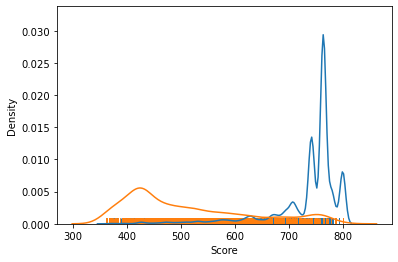

<Figure size 1152x648 with 0 Axes>

In [251]:
def dashboard(min1,max1,cut):
    list = [int(x) for x in np.linspace(min1,max1,cut)]
    for i in range(len(list)):
        if i < cut-1:
                a = (list[i]+list[i+1])/2
                dist.loc[dist['Score'].isin(range(list[i],list[i+1])),'Score'] = a
                i = i + 1
                 
    dist['Score'] = round(dist['Score'],0)
    
    unique_vals = dist['Status'].unique()  
    targets = [dist.loc[dist['Status'] == val] for val in unique_vals]
    
    for target in targets:
        sns.distplot(target[['Score']], hist=False, rug=True)
    plt.ylabel('Density')
    plt.xlabel('Score')
    
    plt.figure(figsize=(16,9))
    
 
dashboard(361,801,30) 

# 6. Based on the Train sample define the intervals for 10 score groups 
(the interval width is defined as (max(score)-min(score))/10 so that we have, for instance 0-100, 100-200 … 900-1000) - reference intervals and reference shares

In [252]:
def intervals(score_intervals):
    
    intervals = pd.cut(score_intervals['Scores'],10)
    score_intervals = pd.concat([intervals, score_intervals.iloc[:,[0,39,40]]],axis = 1)
    score_intervals.columns = ['Intervals','RepDate_end','Scores','will_default']
    score_intervals = score_intervals.reindex(columns=['RepDate_end', 'Scores', 'Intervals', 'will_default'])
    
    return score_intervals

intervals(df)

,RepDate_end,Scores,Intervals,will_default
0,2019-03-31,742.333436,"(712.44, 756.429]",0
1,2019-03-31,671.732838,"(668.45, 712.44]",0
2,2019-02-28,764.040507,"(756.429, 800.419]",0
3,2018-07-31,600.061729,"(580.47, 624.46]",0
4,2019-03-31,764.040507,"(756.429, 800.419]",0
...,...,...,...,...
310301,2018-12-31,742.333436,"(712.44, 756.429]",0
310302,2018-12-31,764.040507,"(756.429, 800.419]",0
310303,2018-06-30,764.040507,"(756.429, 800.419]",0
310304,2018-11-30,800.419077,"(756.429, 800.419]",0


# 8. Calculate PSI for WOE variables over time for each month on Full sample using Train sample as reference

In [253]:
woe_frame = df.iloc[:,20:40]
woe_frame = pd.concat([woe_frame,df['RepDate_end']],axis = 1)

def PSI_m(woe_frame,date):
    
    dict = {}
    sorted_date =  sorted(woe_frame[date].unique())
    k = woe_frame.columns[:-2].tolist()
    complete = pd.DataFrame(columns = k)
    list = [int(x) for x in np.linspace(300,850,20)]
    for i in sorted_date: 
    
        
        dict[i] = [x for x in df.loc[woe_frame[date] == i].index]
        actual = pd.DataFrame(data = woe_frame.iloc[:,:-2] , index = dict[i][0:])
        clon = [x for x in sorted_date if x is not i]
        old = woe_frame.loc[woe_frame[date].isin(clon)]
        old = old.iloc[:,:-2]
        
        

        #for f in range(len(list)):
         #   if f < 19:
          #      actual[f] = np.where((actual['Scores'] >= list[f] ) & (actual['Scores'] < list[f+1]), 1, 0)
           #     old[f] = np.where((old['Scores'] >= list[f] ) & (old['Scores'] < list[f+1]), 1, 0)
            #    f = f + 1
        #old = old.drop('Scores',axis = 1)
        #actual = actual.drop('Scores',axis = 1)
        
        PSI_calc_train = old.sum() / old.shape[0]
        PSI_calc_new =   actual.sum()/ actual.shape[0]
       
       
        PSI = pd.concat([PSI_calc_train,PSI_calc_new],axis = 1)
        PSI = PSI.reset_index()
        PSI.columns = ['index', 'Proportions_Train', 'Proportions_New']
        
        PSI['Original_name'] = PSI['index'].str.split(':').str[0]
        PSI = PSI[np.array(['index', 'Original_name', 'Proportions_Train', 'Proportions_New'])]
        PSI = PSI[(PSI['index'] != 'Intercept')]

        PSI['Contribution'] = np.where((PSI['Proportions_Train'] == 0) | (PSI['Proportions_New'] == 0),
                                       0, (PSI['Proportions_New'] - PSI['Proportions_Train']) * np.log(PSI['Proportions_New'] / PSI['Proportions_Train'])) 
        PSI_summary = PSI.groupby('Original_name')['Contribution'].sum()
        
        
        variables = PSI_summary.tolist()
        indexes = PSI_summary.index.tolist()
        
        
        df2 = pd.DataFrame([variables],columns=indexes)
        
        new_row = {}
        
        for num,p in enumerate(indexes):
                   
                new_row[p] = variables[num]
        
        complete = complete.append(new_row,ignore_index = True)
    complete.insert(0,'Date',sorted_date)
    
    complete.columns = [x.replace('WOE_','') for x in complete.columns]
    return complete
PSI_m(woe_frame,'RepDate_end')

,Date,balance_deal_sum,mob,max_dpd_1,max_dpd_3,max_dpd_6,max_dpd_12,mnths_snc_dpd_gt_0,mnths_snc_dpd_gt_30,mnths_snc_dpd_gt_60,prc_of_month_with_DPD_grt_0_3_months,prc_of_month_with_DPD_grt_0_6_months,prc_of_month_with_DPD_grt_0_12_months,avg_bal_1_avg_bal_3,avg_bal_1_avg_bal_6,avg_bal_1_avg_bal_12,avg_bal_1_3_avg_bal_4_6,avg_arr_1_avg_bal_1,avg_arr_3_avg_bal_3,avg_arr_6_avg_bal_6
0,2018-05-31,0.000209,0.0,0.000739,0.000013,0.000748,0.0,0.012203,0.001840,0.0,0.000074,7.533048e-04,0.000554,0.283450,0.421016,0.000000,0.000000,0.000289,0.000127,0.000330
1,2018-06-30,0.000818,0.0,0.000159,0.000149,0.000193,0.0,0.005970,0.001101,0.0,0.000047,9.090759e-05,0.003263,0.121108,0.338432,0.000000,0.000000,0.000007,0.000015,0.000100
2,2018-07-31,0.003193,0.0,0.000057,0.000533,0.000004,0.0,0.002252,0.000484,0.0,0.000162,5.768832e-05,0.007472,0.050676,0.187539,0.269292,0.172604,0.000023,0.000021,0.000047
3,2018-08-31,0.003894,0.0,0.001752,0.000855,0.000677,0.0,0.000032,0.000159,0.0,0.000247,4.337645e-04,0.000197,0.006818,0.076405,0.064804,0.049863,0.000937,0.000442,0.000289
4,2018-09-30,0.002119,0.0,0.001794,0.001198,0.001387,0.0,0.001217,0.000019,0.0,0.001213,9.955772e-04,0.000820,0.000015,0.006537,0.008388,0.002330,0.001901,0.001513,0.001850
5,2018-10-31,0.000084,0.0,0.001271,0.001620,0.001534,0.0,0.002049,0.000156,0.0,0.002110,9.345750e-04,0.000076,0.007294,0.000408,0.003872,0.002417,0.000022,0.001176,0.000477
6,2018-11-30,0.003311,0.0,0.000058,0.000237,0.000415,0.0,0.000047,0.000169,0.0,0.000389,2.889790e-04,0.000063,0.017395,0.009387,0.016057,0.015059,0.000319,0.000074,0.000112
7,2018-12-31,0.005488,0.0,0.001122,0.000257,0.000008,0.0,0.000068,0.000169,0.0,0.000130,2.347340e-07,0.000281,0.015642,0.039209,0.057353,0.033007,0.000200,0.000259,0.000039
8,2019-01-31,0.004034,0.0,0.001147,0.000174,0.000044,0.0,0.008159,0.000208,0.0,0.000336,1.087280e-05,0.000438,0.021203,0.045721,0.066556,0.039276,0.001821,0.001029,0.000037
9,2019-02-28,0.001448,0.0,0.003977,0.001200,0.000254,0.0,0.000033,0.000148,0.0,0.000921,2.612515e-04,0.000765,0.015114,0.051643,0.077362,0.043549,0.000004,0.000545,0.000297


# 9. Calculate HHI over time for each month on Full sample using reference intervals and reference shares 

In [254]:
hhi = df.loc[:,['RepDate_end','Scores']]
def HHI(min1,max1,cut,var):
    list = [int(x) for x in np.linspace(min1,max1,cut)]
    hhi['New_Score'] = 0
    for i in range(len(list)):
            if i < cut-1:
                a = (list[i]+list[i+1])/2
                hhi.loc[hhi[var].between(list[i],list[i+1]),'New_Score'] = a 
                i = i + 1
    hhi['New_Score'] = round(hhi['New_Score'],0)
    hhi1 = hhi.groupby(["RepDate_end","New_Score"]).count()
    hhi1 = hhi1.reset_index()
    complete = pd.DataFrame(columns = ['RepDate_end','Whole Concentration'])
    hhi1.rename(columns={'RepDate_end': 'RepDate_end', 'New_Score': 'NS','Scores': 'Amount'}, inplace=True)
    for i in hhi1['RepDate_end'].unique():   
            test = pd.DataFrame(hhi1.loc[hhi1['RepDate_end'] == i])
            test['pop'] = test['Amount'] / test['Amount'].sum()
            test['Concentration'] = test['pop']**2
            test['Whole Concentration'] = test['Concentration'].sum()
            
            test = test.iloc[:,[0,5]][:1]
            complete = pd.concat([complete,test],axis = 0)
    
    complete.reset_index(drop=True)  
    return complete

    
    
HHI(360,801,10,'Scores')

,RepDate_end,Whole Concentration
0,2018-05-31,0.380424
9,2018-06-30,0.382858
18,2018-07-31,0.380926
27,2018-08-31,0.373473
36,2018-09-30,0.373962
45,2018-10-31,0.380048
54,2018-11-30,0.392867
63,2018-12-31,0.406203
72,2019-01-31,0.391563
81,2019-02-28,0.404981


In [255]:
woe_train = woe_char.iloc[0:280000,:]
woe_test = woe_char.iloc[280000:,:]
def calculate_psi(expected, actual, buckettype='bins', buckets=1000, axis=0):

    def psi(expected_array, actual_array, buckets):

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input


        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])



        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])
    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = np.empty(len(expected.shape))
        else:
            psi_values = np.empty(expected.shape[axis])
    
    return psi_values

calculate_psi(woe_train, woe_test, buckettype='bins', buckets=10, axis=1)

array([8.52586184e-312, 8.52728674e-312, 8.52205784e-312, 8.52205786e-312,
       8.52205786e-312, 8.52205785e-312, 8.52205785e-312, 8.52205780e-312,
       8.52205779e-312, 8.52205779e-312, 8.52488989e-312, 8.52488988e-312,
       8.52821926e-312, 8.52205780e-312, 8.52205780e-312, 8.52205779e-312,
       8.52205779e-312, 8.52205780e-312, 8.52205780e-312, 8.52205779e-312])

# END --------------------------------------------------------------------------------------------------------

In [256]:
col = pd.read_csv('Customer_Scor.csv')
col['will_default'] = np.where(col['will_default'].isin([0]),1,0)

In [257]:
train = col.loc[col['Train_test'] == 1]
test = col.loc[col['Train_test'] == 0]
nan = col.loc[col['Train_test'].isnull()]

# QUESTIONS

# 2 и 3 вопрос  ---> Чтобы подсчитать roc_auc --> gini мне нужна переменная которую запредиктила модель и will_deafult.

# 4 и 5 вопрос  ---> Правильно ли я понимаю что я должен считать gini для каждого woe по принципу что roc_auc_score(will_default,'каждая переменная от WOE')

# В PSI формуле с kaggle есть баг, оно считает PSI не по колонкам а по строчкам и результаты очень мелнькие (ex: 23/1000000000000)

# В новых данных которые мне скинули вчера в колонке Train_test много NAN values  , как мне их определить?

# ---------------------------------------------------------------------------------------------------------------

# 4. Calculate Gini for each WOE characteristic on Train and Test samples

In [258]:
woe_train = train.iloc[:,2:-2]
woe_test = test.iloc[:,2:-2]
def Gini_for_charact(train,test):
    list = [train,test]
    scores = []
    for i in list:
        for g in i.columns[1:]:

            gini = roc_auc_score(i.iloc[:,0].values,i[g])*2 - 1
            
            scores.append(gini)
        
    train_scores = scores[0:8]
    test_scores = scores[8:]
    summary = pd.DataFrame({'Woe_Characteristics':woe_train.columns.values[1:] , 'Train_Gini':train_scores , 'Test_Gini': test_scores})
    return summary
Gini_for_charact(woe_train,woe_test)

,Woe_Characteristics,Train_Gini,Test_Gini
0,WOE_max_dpd_3,0.686346,0.664987
1,WOE_avg_arr_6_avg_bal_6,0.685995,0.649217
2,WOE_mnths_snc_dpd_gt_60,0.000000,0.000000
3,WOE_avg_bal_1_avg_bal_3,0.266012,0.272968
4,WOE_avg_bal_1_3_avg_bal_4_6,0.160175,0.176176
5,WOE_balance_deal_sum,0.112246,0.135286
6,WOE_age,0.048264,0.011070
7,WOE_marital_status,0.124872,0.120419


# 5. Calculate Gini for each WOE characteristic over time for each month on Full sample

In [259]:
woe_train_date = pd.concat([woe_train,col['RepDate_end']],axis = 1)
def Gini_for_charact(df,woe_train_date):
    train = pd.DataFrame(data = df,columns = woe_train_date.columns.values)
    sorted_date = sorted(df['RepDate_end'].unique())
    dict = {}
    summary1 = pd.DataFrame()
    for i in sorted_date: 
        scores = []
        dict[i] = [x for x in df.loc[df['RepDate_end'] == i].index]
        clon = pd.DataFrame(data = train , index = dict[i][0:])
        #return clon

        for g in clon.columns[1:]:
            gini = roc_auc_score(clon.iloc[:,0].values,clon[g])*2 - 1
            scores.append(gini)
    
            summary = pd.DataFrame()
            summary = pd.DataFrame(columns = [i] , data = scores )
    
        
        summary1 = pd.concat([summary1,summary],axis = 1)
    summary1.insert(0,'Characteristics',woe_train_date.columns.values[1:])
        
    return summary1.head(25)
Gini_for_charact(col,woe_train)

,Characteristics,28_02_2019,30_04_2019,30_06_2018,30_09_2018,30_11_2018,31_01_2019,31_03_2019,31_05_2018,31_07_2018,31_08_2018,31_10_2018,31_12_2018
0,WOE_max_dpd_3,0.696962,0.657162,0.682283,0.688365,0.725469,0.723978,0.688388,0.692529,0.691765,0.697464,0.714268,0.715069
1,WOE_avg_arr_6_avg_bal_6,0.681545,0.667943,0.696876,0.684875,0.707657,0.678901,0.683368,0.704110,0.692319,0.690754,0.698454,0.699661
2,WOE_mnths_snc_dpd_gt_60,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,WOE_avg_bal_1_avg_bal_3,0.307743,0.279738,0.297587,0.307492,0.277284,0.312349,0.321378,0.313255,0.296195,0.312616,0.275793,0.318025
4,WOE_avg_bal_1_3_avg_bal_4_6,0.186540,0.199954,0.209663,0.174960,0.175761,0.168632,0.181975,0.211184,0.187250,0.174995,0.166429,0.162181
5,WOE_balance_deal_sum,0.140362,0.137987,0.133337,0.135916,0.122359,0.125657,0.135634,0.139659,0.119748,0.122647,0.125675,0.125871
6,WOE_age,0.065108,0.064961,0.029090,0.036049,0.037893,0.058094,0.060558,0.030673,0.025798,0.030546,0.040135,0.051826
7,WOE_marital_status,0.154959,0.145721,0.117252,0.117258,0.135213,0.143704,0.142600,0.115228,0.120571,0.121191,0.122024,0.136222
